In [1]:
from net.FPN import FPN
import sys
import numpy as np
import random
import math
from eval.eval_by_cropping import eval_model
from Dataset.EvalDatasetConstructor import EvalDatasetConstructor
from Dataset.TrainDatasetConstructor import TrainDatasetConstructor
from metrics import AEBatch, SEBatch
from PIL import Image
import time
import torch
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda:5")
torch.cuda.set_device(cuda_device)
# torch.backends.cudnn.benchmark=True
%matplotlib inline

In [2]:
# config
config = {
'min_mae':10240000,
'min_loss':10240000,
'eval_num':182,
'train_num':300,
'learning_rate': 1e-4,
'train_batch_size': 5,
'epoch': 20000,
'eval_per_step': 60,
'mode':'crop',
'if_random_hsi':True,
'if_flip':True,
'stage':'numeration',
'gt_map_path':"/home/zzn/Document/Datasets/part_A_final/train_data/gt_map_w_net",
'img_path':"/home/zzn/Document/Datasets/part_A_final/train_data/images",
'cuda_device':cuda_device,
'gt_map_path_t':"/home/zzn/Document/Datasets/part_A_final/test_data/gt_map_w_net",
'img_path_t':"/home/zzn/Document/Datasets/part_A_final/test_data/images",
'gt_path_t':"/home/zzn/Document/Datasets/part_A_final/test_data/ground_truth",
'model_save_path':"/home/zzn/PycharmProjects/NAS_FPN/StateDicts/"
}

In [4]:
# data_load
train_dataset = TrainDatasetConstructor(
    config['img_path'],
    config['gt_map_path'],
    config['train_num'],
    mode=config['mode'],
    stage=config['stage'],
    device=config['cuda_device'],
    if_random_hsi=config['if_random_hsi'],
    if_flip=config['if_flip'])
eval_dataset = EvalDatasetConstructor(
    config['img_path_t'],
    config['gt_map_path_t'],
    config['eval_num'],
    mode=config['mode'],
    stage=config['stage'],
    device=config['cuda_device'])
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=config['train_batch_size'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [3]:
# model construct
net = FPN().to(config['cuda_device'])
# net = torch.nn.DataParallel(model, device_ids=[6, 7], output_device=cuda_device).to(config['cuda_device'])
optimizer = torch.optim.Adam(net.parameters(), config['learning_rate'])
criterion = torch.nn.MSELoss(reduction='sum').to(config['cuda_device'])
ae_batch = AEBatch().to(config['cuda_device'])
se_batch = SEBatch().to(config['cuda_device'])
modules = {
    'model': net,
    'shape': None,
    'ae': ae_batch,
    'se': se_batch,
    'loss': criterion
}

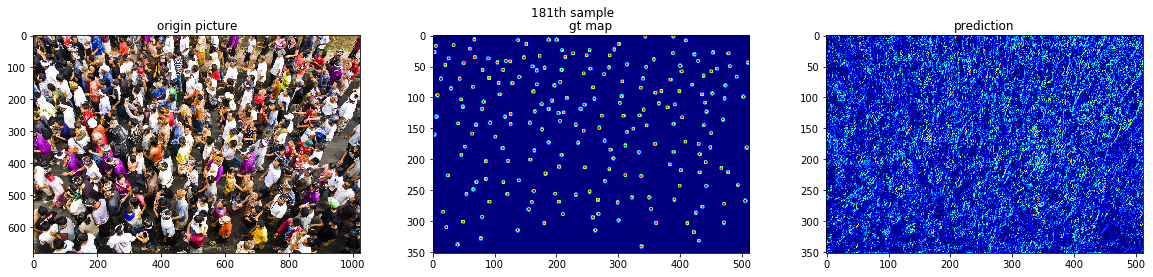

The gt counts of the above sample:216, and the pred counts:1179.4603271484375
In step 0, epoch 0, loss = 18.621711200410193, eval_mae = 336.5005798339844, eval_rmse = 424.45458984375, time cost eval = 38.1302809715271s
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])
torch.Size([5, 3, 400, 400])


In [ ]:
step = 0
eval_loss = []
eval_mae = []
eval_rmse = []
for epoch_index in range(config['epoch']):
    dataset = train_dataset.shuffle()
    loss_list = []
    time_per_epoch = 0
    for train_img_index, train_img, train_gt in train_loader:
        if step % config['eval_per_step'] == 0:
            validate_MAE, validate_RMSE, validate_loss, time_cost = eval_model(
                config, eval_loader, modules, True)
            eval_loss.append(validate_loss)
            eval_mae.append(validate_MAE)
            eval_rmse.append(eval_rmse)
            sys.stdout.write(
                'In step {}, epoch {}, loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(step, epoch_index, validate_loss, validate_MAE,
                        validate_RMSE, time_cost))
            sys.stdout.flush()
            #             save model
            if config['stage'] == 'numeration' and config[
                    'min_mae'] > validate_MAE:
                config['min_mae'] = validate_MAE
                torch.save(net.state_dict(), config['model_save_path'])
        net.train()
        torch.cuda.empty_cache()
        x = train_img
        y = train_gt
        start = time.time()
        prediction = net(x)
        loss = criterion(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.data.item())
        optimizer.step()

        step += 1
        torch.cuda.empty_cache()
        end = time.time()
        time_per_epoch += end - start

In [ ]:
import torch
torch.multiprocessing.set_start_method('spawn')

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel
import os

def dist_init(host_addr, rank, local_rank, world_size, port=23456):
    host_addr_full = 'tcp://' + host_addr + ':' + str(port)
    torch.distributed.init_process_group("nccl", init_method=host_addr_full,
                                         rank=rank, world_size=world_size)
    num_gpus = torch.cuda.device_count()
    torch.cuda.set_device(local_rank)
    assert torch.distributed.is_initialized()

rank = 0
local_rank = 0
world_size = 2
# get_ip函数自己写一下 不同服务器这个字符串形式不一样
# 保证所有task拿到的是同一个ip就成
ip = get_ip(os.environ['SLURM_STEP_NODELIST'])

dist_init(ip, rank, local_rank, world_size)


# 接下来是写dataset和dataloader，这个网上有很多教程
# 我这给的也只是个形式，按自己需求写好就ok
dataset = your_dataset()  #主要是把这写好
datasampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank)
dataloader = DataLoader(dataset, batch_size=batch_size_per_gpu, sampler=source_sampler)

model = your_model()     #也是按自己的模型写
model = DistributedDataPrallel(model, device_ids=[local_rank], output_device=local_rank)

# 此后训练流程与普通模型无异